# Mem ops:

Explanation of different memory ops:

We model memory operations as two functions on an array $A$ of fixed size $N$:
1. A write operation that sets memory location $a_j$ to value $x$
2. A read operation that reads memory location $a_i$ and returns the value as $y$

Since the read and write ops boil down to $a_j = x$ and $y = a_i$, I denote the read and write values at given indexes $y_i$ and $x_j$ for readability.

![mem ops](imgs/mem_op_diagram.png)

Now there are three partial derivatives we care about:
1. $\frac{dy_i}{dx_j}$: The derivative of the read value w.r.t. the written value
2. $\frac{dy_i}{di}$: The derivative of the read index w.r.t. the read value
3. $\frac{dy_i}{dj}$: The derivative of the write index of a given write w.r.t. the read value. 

## $dy_i/dx_j$:

Since the read value = the write value when i == j this is trivially:

$$
\frac{dy_i}{dx_j} = 
    \begin{cases} 
      1 & i = j \\
      0 & i \neq j
   \end{cases} \\
$$

## $dy_i/di$:

This describes how changing the read index $i$ will change the read value. Obviously this can't be evaluated directly but we can approximate it by approximating the read op as a weighted sum of smoothed values that is differentiable. Any function that is smooth and continuous and has a single global maximum should work, the normal distribution seems like a reasonable choice for this.


$$
y_i = read(x, i) = \sum_{j=1}^{N} \frac{x_j}{\sqrt{2\pi\sigma^2}} e^{-\frac{(i-j)^2}{2\sigma^2}}\\
\frac{dy_i}{di} = \sum_{j=1}^{N} -\frac{x_j}{\sqrt{2\pi}\sigma^3} e^{-\frac{(i-j)^2}{2\sigma^2}} (i-j)
$$

<!---\frac{dy_i}{j} & = x_j e^{-abs(i-j)} \frac{i-j}{abs(i-j)}--->

Note the normal distribution has a parameter $\sigma$ that we need to set, probably as some function of the size of the array.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

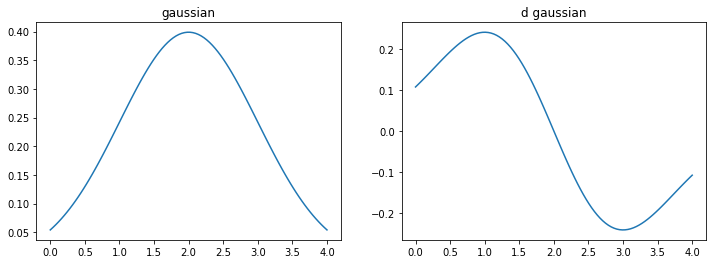

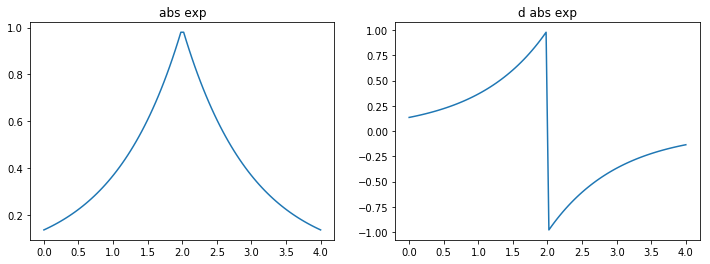

In [4]:
def get_gauss(sigma):
    def gaussian(x_j, i, j):
        return x_j / (np.sqrt(2*np.pi*sigma**2)) *\
                    np.exp(-(i - j)**2/(2*sigma**2))
    return gaussian

def get_d_gauss_di(sigma):
    def d_gauss_di(x_j, i, j):
        return - x_j / (np.sqrt(2*np.pi*sigma**6)) *\
                np.exp(-(i - j)**2/(2*sigma**2)) *\
                (i - j)
    return d_gauss_di

def get_d_gauss_dj(sigma):
    def d_gauss_dj(x_j, i, j):
        return - x_j / (np.sqrt(2*np.pi*sigma**6)) *\
                np.exp(-(i - j)**2/(2*sigma**2)) *\
                (i - j)
    return d_gauss_dj

def abs_exp(x_j, i, j):
    return x_j * np.exp(-np.abs(i - j))

def d_abs_exp(x_j, i, j):
    return -x_j * np.exp(-np.abs(i - j)) * (i - j) / np.abs(i - j)


def test():
    i = np.linspace(0, 4, 100)
    j = 2
    sigma = 1
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    gauss = get_gauss(1)
    plt.plot(i, gauss(1.0, i, j))
    plt.title('gaussian')

    plt.subplot(1,2,2)
    plt.plot(i, get_d_gauss_di(1)(1.0, i, j))
    plt.title('d gaussian')

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(i, abs_exp(1.0, i, j))
    plt.title('abs exp')

    plt.subplot(1,2,2)
    plt.plot(i, d_abs_exp(1.0, i, j))
    plt.title('d abs exp')
    
test()

/Users/gryan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


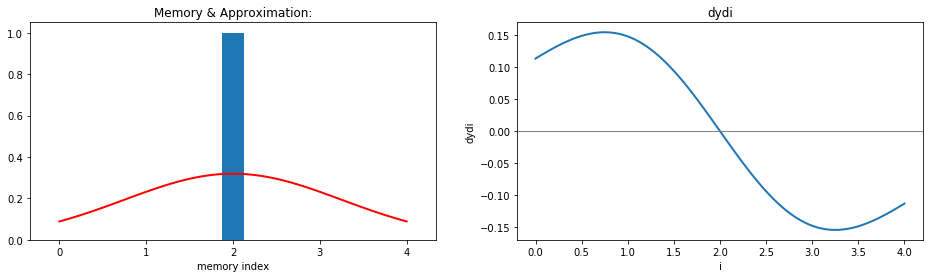

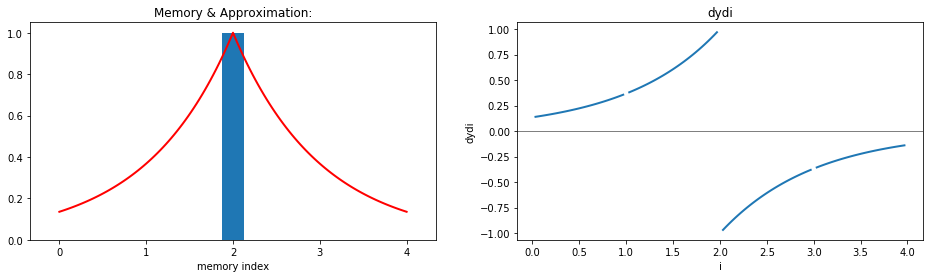

In [7]:
def sim_read(A, i, filt):
    y = np.zeros(len(i))
    for j in range(len(A)):
        y += filt(A[j], i, j)
    return y

def dyidi(A, i, d_filt):
    dy = np.zeros(len(i))
    for j in range(len(A)):
        dy += d_filt(A[j], i, j)
    return dy

def viz_read(A, filt, d_filt):
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.bar(np.arange(len(A)), A, width=0.25)
    plt.axhline(linewidth=1,color='gray')
    plt.title('Memory & Approximation:')
    
    all_i = np.linspace(0, len(A)-1, len(A)*25)
    y = sim_read(A, all_i, filt)
    plt.plot(all_i, y, 'r', linewidth=2)
    plt.xlabel('memory index')
    
    plt.subplot(1,2,2)
    plt.plot(all_i, dyidi(A, all_i, d_filt),
            linewidth=2)
    plt.axhline(linewidth=1,color='gray')
    plt.title('dydi')
    plt.xlabel('i')
    plt.ylabel('dydi')
    
A = np.zeros(5)
A[2] = 1
sigma = len(A)/4
viz_read(A, get_gauss(sigma), get_d_gauss_di(sigma))
viz_read(A, abs_exp, d_abs_exp)



The above example shows the approximation for a single central set value. We can also experiment with different memory values.

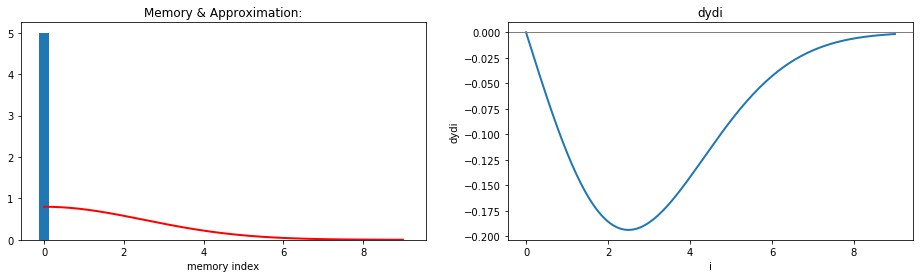

In [8]:
A = np.zeros(10)
A[0] = 5
# A[3] = -1
# A[9] = 10
sigma = len(A)/4
viz_read(A, get_gauss(sigma), get_d_gauss_di(sigma))

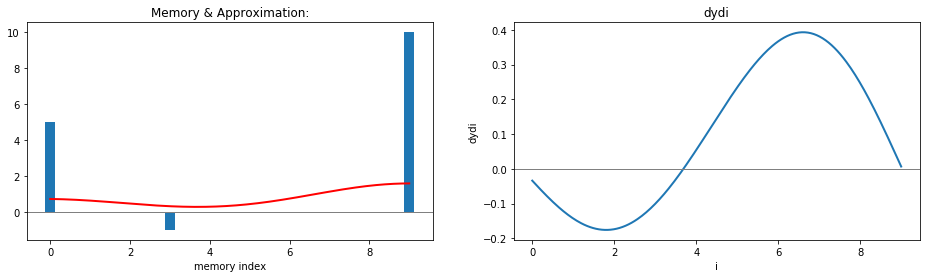

In [9]:
A = np.zeros(10)
A[0] = 5
A[3] = -1
A[9] = 10
sigma = len(A)/4
viz_read(A, get_gauss(sigma), get_d_gauss_di(sigma))

In this example setting $i = 9$ will maximize $y$. However, if $i < \approx 3.8$ it will be drawn down to the $0$ index instead. Also note that minimization will incorrectly fall to $4$, not $3$, since the two large positive values swamp the negative value. If this becomes a problem using log scale values could potentially address it.

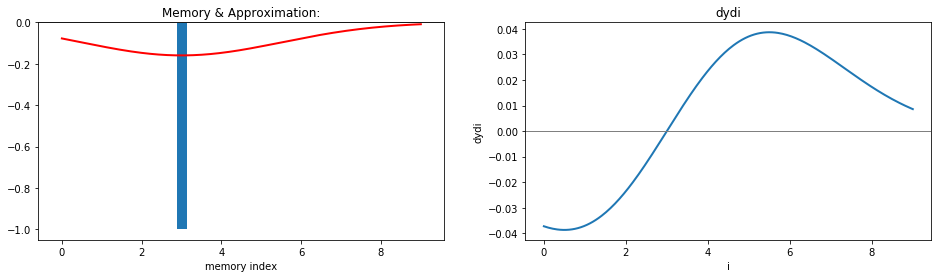

In [10]:
A = np.zeros(10)
A[3] = -1
sigma = len(A)/4
viz_read(A, get_gauss(sigma), get_d_gauss_di(sigma))

## $dy_i/dj$:

This describes how changing the write index $j$ will change the read value. Similarly to the read op, this is approximated as a weighted sum of smoothed values, but the differentiation is w.r.t. the write index.

$$
y_i = read(x, i) = \sum_{j=1}^{N} \frac{x_j}{\sqrt{2\pi\sigma^2}} e^{-\frac{(i-j)^2}{2\sigma^2}}\\
\frac{dy_i}{dj} = \frac{x_j}{\sqrt{2\pi}\sigma^3} e^{-\frac{(i-j)^2}{2\sigma^2}} (i-j)
$$

<!---\frac{dy_i}{j} & = x_j e^{-abs(i-j)} \frac{i-j}{abs(i-j)}--->


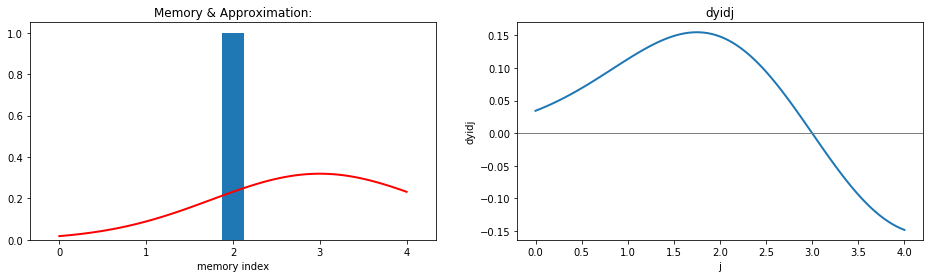

In [17]:
def get_d_gauss_dj(sigma):
    def d_gauss_dj(x_j, i, j):
        return x_j / (np.sqrt(2*np.pi*sigma**6)) *\
                np.exp(-(i - j)**2/(2*sigma**2)) *\
                (i - j)
    return d_gauss_dj

def sim_write(x_j, i, j, filt):
    return filt(x_j, i, j)


def dyidj(x_j, i, j, d_filt):
    return d_filt(x_j, i, j)
#     return x_j / (np.sqrt(2*np.pi*sigma**6)) *\
#                 np.exp(-(i - j)**2/(2*sigma**2)) *\
#                 (i - j)

def viz_write(A, i, j, filt, d_filt):
    
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.bar(np.arange(len(A)), A, width=0.25)
    plt.axhline(linewidth=1,color='gray')
    plt.title('Memory & Approximation:')
    
    all_j = np.linspace(0, len(A)-1, len(A)*25)
    y = sim_write(A[j], i, all_j, filt)
    plt.plot(all_j, y, 'r', linewidth=2)
    plt.xlabel('memory index')
    
    plt.subplot(1,2,2)
    plt.plot(all_j, dyidj(A[j], i, all_j, d_filt),
            linewidth=2)
    plt.axhline(linewidth=1,color='gray')
    plt.title('dyidj')
    plt.xlabel('j')
    plt.ylabel('dyidj')
    
A = np.zeros(5)
A[2] = 1
sigma = len(A)/4
viz_write(A, 3, 2, get_gauss(sigma), get_d_gauss_dj(sigma))

Note that the partial derivative for a single write index w.r.t. to a single read is just going to be a gaussian centered on the read index. However, during gradient descent the gradient will take into account partial deriviatives from all of the read indexes relevant to target output, which may result in behavior similar to the read index summary derivatives.

## Quicksort test:

quicksort test:
[2, 3, 7, 8, 9, 6, 5, 1, 0, 4]


/Users/gryan/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


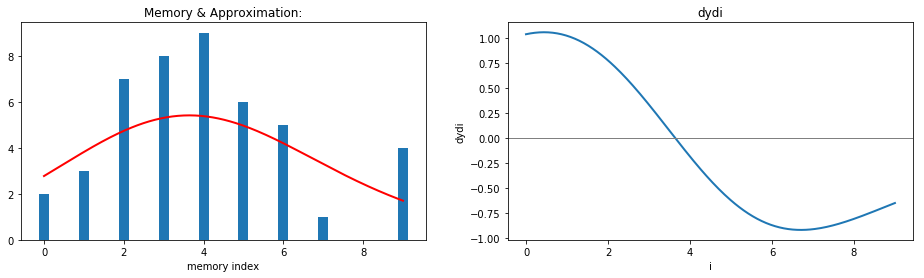

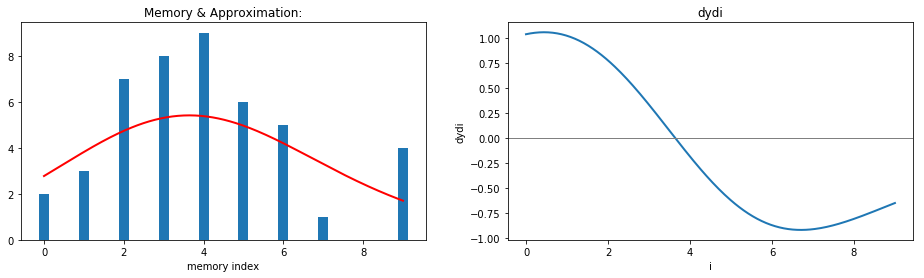

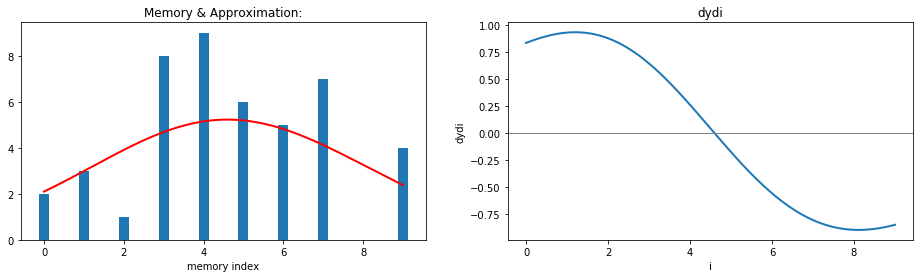

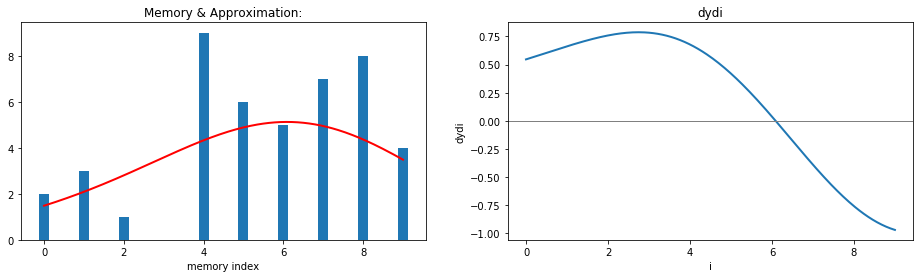

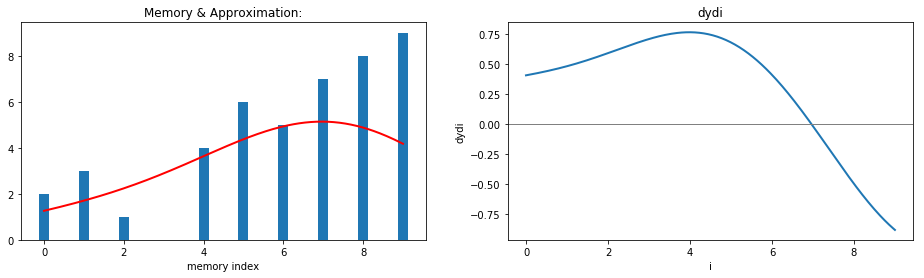

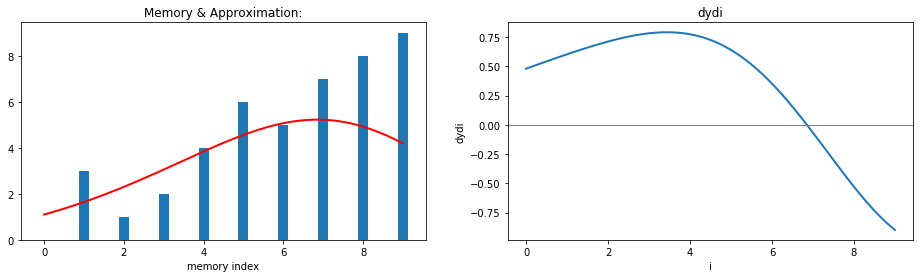

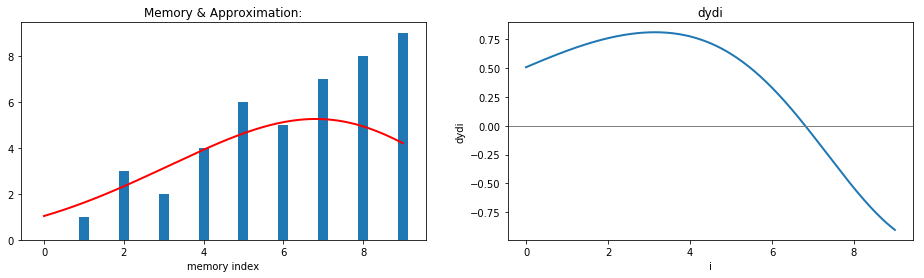

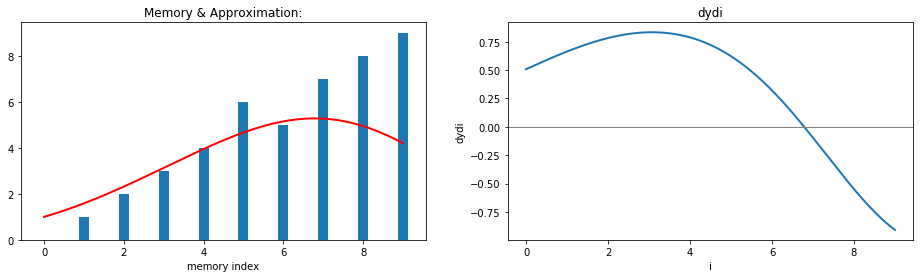

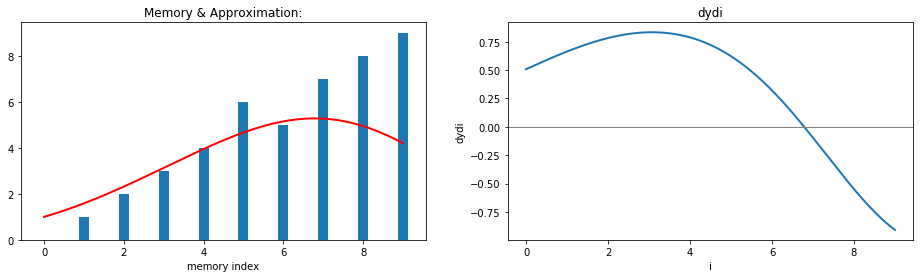

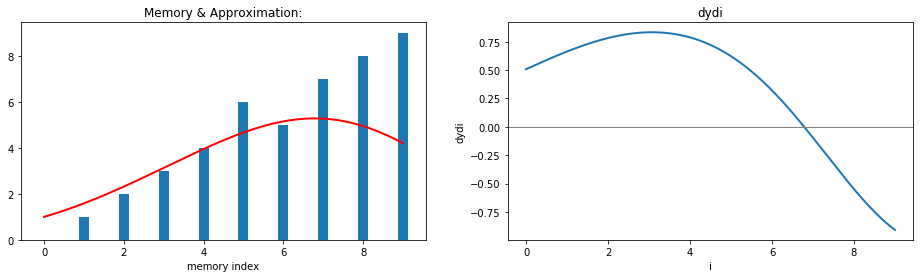

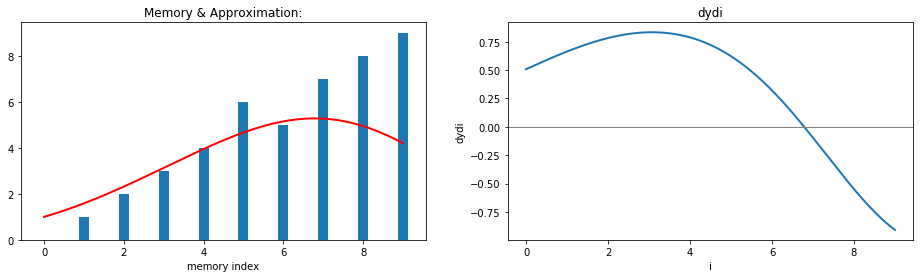

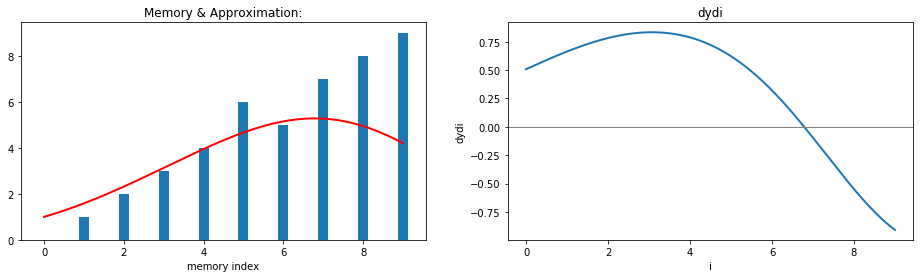

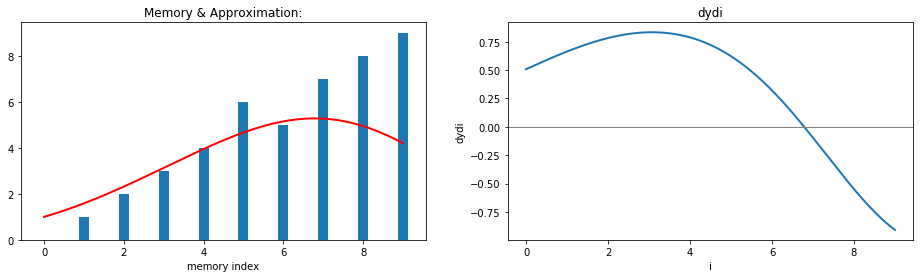

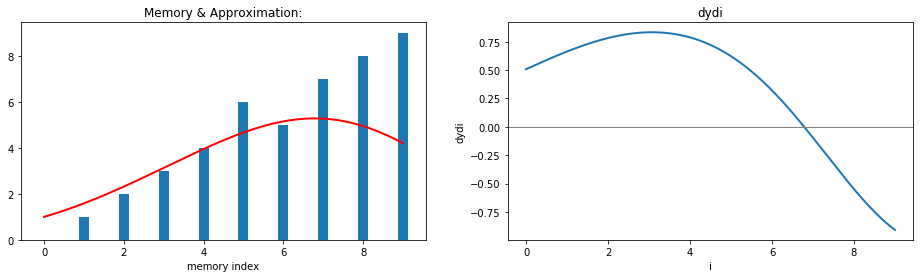

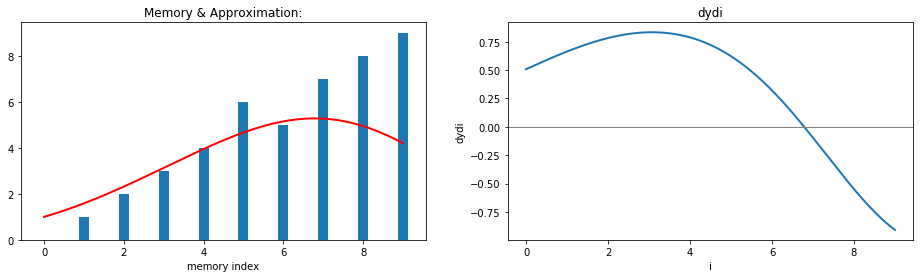

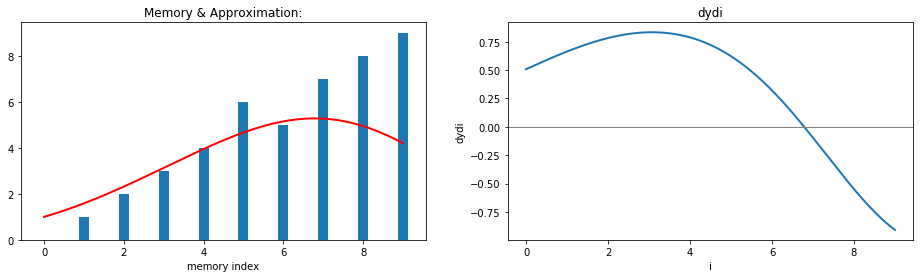

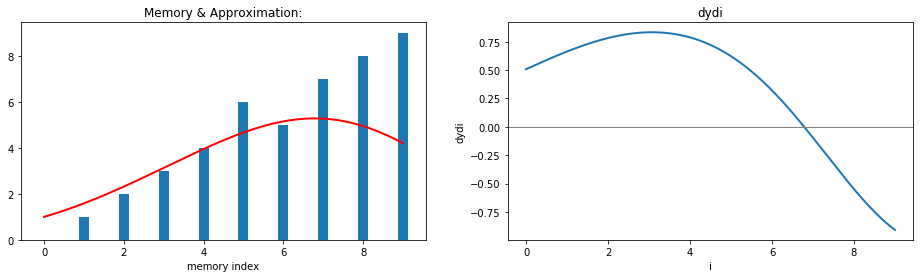

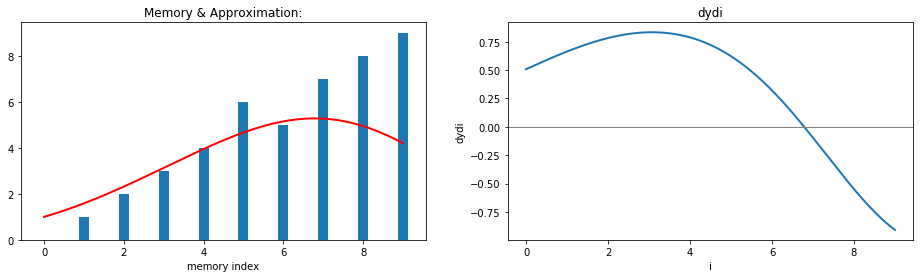

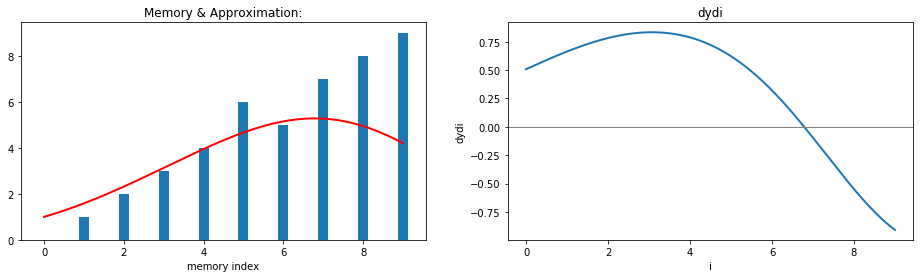

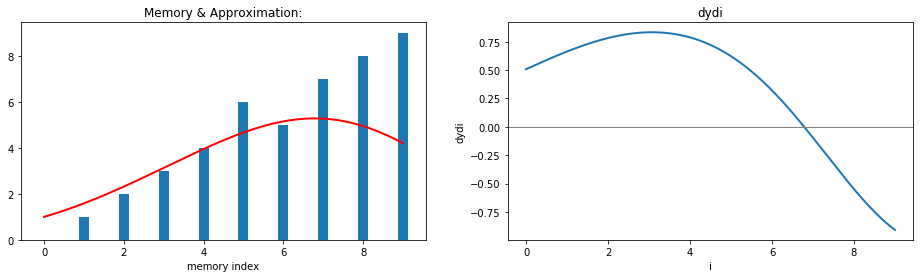

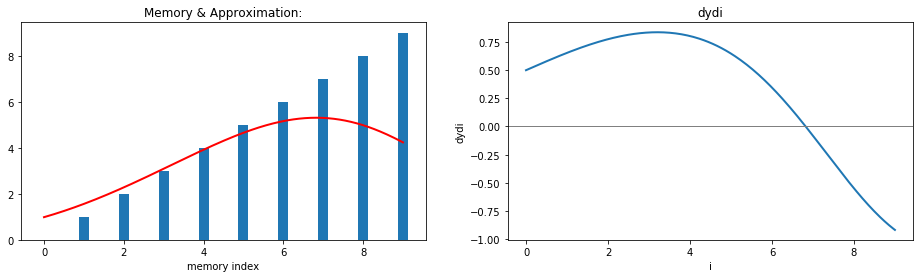

In [17]:
import random
import mem_ops as mem

def quicksort(A, lo, hi):
    if (lo < hi):
        p = partition(A, lo, hi)
        quicksort(A, lo, p-1)
        quicksort(A, p+1, hi)

def partition(A, lo, hi):
    pivot = A[hi]
    i = lo
    for j in range(lo, hi):
        if (A[j] < pivot):
            swap(A, i, j)
            i = i + 1
    
    swap(A, i, hi) 
    return i

def swap(A, i, j):
    tmp = A[i]
    A[i] = A[j]
    A[j] = tmp
    
    sigma = len(A)/4
    mem.viz_read(A, mem.get_gauss(sigma), mem.get_d_gauss_di(sigma))
    
print('quicksort test:')
test = list(range(10))
random.shuffle(test)
print(test)
quicksort(test, 0, len(test)-1)
print(test)